In [71]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [75]:
import os

# Define the path to the TESS dataset
tess_path = r"C:\Users\neera\TESS Toronto emotional speech set data"

# Initialize empty lists to store the audio files and their corresponding emotions
audio_files = []
emotions = []

# Recursively search for audio files in all subdirectories
for root, dirs, files in os.walk(tess_path):
    for file in files:
        if file.endswith('.wav'):
            audio, sr = librosa.load(os.path.join(root, file))
            audio_files.append(audio)
            emotion = file.split('_')[2].split('.')[0]  # Extract the emotion label from the file name
            emotions.append(emotion)

# Print the number of audio files and emotions
print(f"Number of audio files: {len(audio_files)}")
print(f"Number of emotions: {len(emotions)}")

Number of audio files: 5600
Number of emotions: 5600


In [77]:
# Convert the emotions list to a numpy array
emotions = np.array(emotions)

# One-hot encode the emotions
le = LabelEncoder()
emotions_encoded = to_categorical(le.fit_transform(emotions))

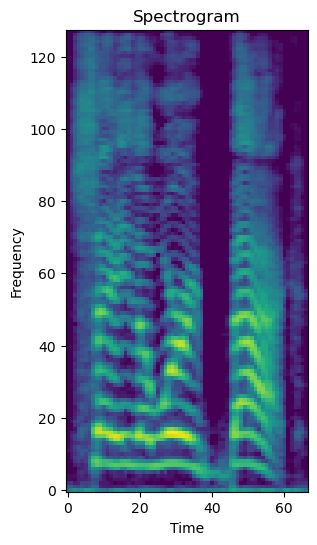

In [81]:
# Plot the spectrogram of the selected sample
spectrogram = librosa.feature.melspectrogram(y=audio_files[0], sr=16000)
plt.figure(figsize=(12, 6))
plt.imshow(librosa.power_to_db(spectrogram, ref=np.max), origin='lower')
plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [87]:
# Calculate spectrograms for all audio files
spectrograms = []
for audio in audio_files:
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=16000)
    spectrograms.append(spectrogram)

In [89]:
# Extract Mel-Frequency Cepstral Coefficients (MFCCs) from spectrograms
mfccs = []
for spectrogram in spectrograms:
    mfcc = librosa.feature.mfcc(S=spectrogram, n_mfcc=13)
    mfccs.append(mfcc)

In [91]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mfccs, emotions_encoded, test_size=0.2, random_state=42)

In [109]:
from keras.layers import Flatten
# Pad the arrays in the mfccs list
max_length = max([len(mfcc) for mfcc in mfccs])
min_features = min([len(mfcc[0]) for mfcc in mfccs])

# Trim or pad the arrays to have the same number of features
padded_mfccs = []
for mfcc in mfccs:
    trimmed_mfcc = [frame[:min_features] for frame in mfcc]
    padded_mfcc = pad_sequences([trimmed_mfcc], maxlen=max_length, padding='post')[0]
    padded_mfccs.append(padded_mfcc)

# Convert the list of arrays into a single numpy array
padded_mfccs_array = np.array(padded_mfccs)

# Reshape the array for CNN-LSTM input
mfccs_reshaped = padded_mfccs_array.reshape((padded_mfccs_array.shape[0], padded_mfccs_array.shape[1], min_features, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfccs_reshaped, emotions_encoded, test_size=0.2, random_state=42)

# Define the CNN-LSTM model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], min_features, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Reshape((52, 80)))  # Reshape to 3D
model.add(LSTM(64, dropout=0.2))
model.add(Dense(emotions_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.3510 - loss: 1.6652 - val_accuracy: 0.6804 - val_loss: 0.9107
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.7105 - loss: 0.8366 - val_accuracy: 0.8027 - val_loss: 0.5805
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8293 - loss: 0.5277 - val_accuracy: 0.8741 - val_loss: 0.3857
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.8644 - loss: 0.3941 - val_accuracy: 0.8777 - val_loss: 0.3318
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8994 - loss: 0.3151 - val_accuracy: 0.9116 - val_loss: 0.2741
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.9169 - loss: 0.2700 - val_accuracy: 0.9107 - val_loss: 0.2778
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9152 - loss: 0.2518 - val_accuracy: 0.9268 - val_loss: 0.2300
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9358 - loss: 0.1848 - 

In [111]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')

# Make predictions on the test data
predictions = model.predict(X_test)

# Convert the predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model using classification metrics
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report:')
print(classification_report(np.argmax(y_test, axis=1), predicted_classes))
print('Confusion Matrix:')
print(confusion_matrix(np.argmax(y_test, axis=1), predicted_classes))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9870 - loss: 0.0583
Test accuracy: 0.99
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       176
           1       1.00      0.99      0.99       153
           2       1.00      0.99      0.99       149
           3       1.00      1.00      1.00       143
           4       0.99      0.95      0.97       175
           5       0.99      0.99      0.99       165
           6       0.95      1.00      0.97       159

    accuracy                           0.99      1120
   macro avg       0.99      0.99      0.99      1120
weighted avg       0.99      0.99      0.99      1120

Confusion Matrix:
[[174   0   0   0   0   2   0]
 [  2 151   0   0   0   0   0]
 [  0   0 147   0   2   0   0]
 [  0   0   0 143   0   0   0]
 [  0   0   0   0 167   0   8]
 [  0   0   0   0   0 164   1]
 [  0   0   0   0   0   0 159]]


In [113]:
# Save the model to a file
model.save('emotion_recognition_model.h5')

# Print a success message
print('Model saved successfully!')

Model saved successfully!
